In [ ]:
#IMPORT 

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
from keras import layers
from keras import Model
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
import numpy as np
from nltk.tokenize import TweetTokenizer
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from tqdm import tqdm
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline 

Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow_hub'

In [ ]:
#DATASET PATH 
#FUNCTION LOAD DATA

path = 'MVSC Tweet Corpus.txt'
def load_data():
    tweet_data = pd.read_csv(path, 
                            encoding= 'unicode_escape', 
                            sep='\t', engine='python', 
                            error_bad_lines=False)
    return tweet_data

In [ ]:
#LOAD DATA IN TO DATA FRAME TWEET_DATA

tweet_data = load_data()
df = pd.DataFrame(tweet_data[['tweet_id', 'tweet_text', 'user_id']])

In [ ]:
#TWEET PRE-PROCESSING

tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
en_stop_words = set(stopwords.words('english'))
en_stop_words.add("rt")
df['orig_tweet'] =df['tweet_text']
df['text'] = df['tweet_text'].apply(tokenizer.tokenize).apply(" ".join)
df['text'] = df['text'].apply(lambda s: s.translate(str.maketrans('','', string.punctuation)).lower())
df['text'] = df['text'].replace(r'http\S+', '', regex = True) #REMOVE URLS
#df['text'] = df['text'].replace(r'(?:\#+[\w_]+[\w\'_\-]*[\w_]+)', '', regex=True)
df['text'] = df['text'].replace(r'(?:@[\w_]+)','you', regex = True)
df['text'] = df['text'].replace(r'[^\w\s]','', regex = True)
#df['text'] = df['text'].replace(r"(.)\1{2,}",r"\1",regex=True)
df['text'] = df['text'].replace('\t', '')
df['tokenized_text'] = df['text'].apply(tokenizer.tokenize)
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [w for w in x if not w in en_stop_words if len(x) > 1])
df['processed_text'] = df['tokenized_text'].apply(" ".join)

#create df_tweet /tweet_id /text /user_id /processed_text
df_tweet = pd.DataFrame(df[['tweet_id', 'tweet_text', 'user_id', 'processed_text']])

In [ ]:
df_tweet.head()

,tweet_id,tweet_text,user_id,processed_text
0,"6,97E+17",#MARVEL #COMICS Deadpool & the Mercs for Money...,2873144464,marvel comics deadpool mercs money 1 hip hop v...
1,"6,97E+17",#HughJackman Plays Coy on Possible Wolverine C...,2603224578,hughjackman plays coy possible wolverine cameo...
2,"6,97E+17",Blake Lively and Ryan Reynolds attend the 'Dea...,17637890,blake lively ryan reynolds attend deadpool fan...
3,"6,97E+17",Really hope Deadpool is still showing when I g...,196255919,really hope deadpool still showing get back en...
4,"6,97E+17","deadpool here, deadpool there. okay.",271503690,deadpool deadpool okay


In [ ]:
def extract_2(a, b, c):
    i = 0
    aux = []
    while i < len(a):
        if(a[i] == b[i] and b[i] == c[i]):
            aux.append(a[i])
            i += 1
        else:
            if(a[i] == b[i] and b[i] != c[i]):
                aux.append(a[i])
                i += 1
            else:
                if(a[i] != b[i] and b[i] == c[i]):
                    aux.append(b[i])
                    i += 1
                else:
                    if(a[i] != b[i] and a[i] == c[i]):
                        aux.append(a[i])
                        i += 1
    return aux

def extract_over3(a, b, c):
    i = 0
    aux = []
    while i < len(a):
        if(a[i] == b[i] and b[i] == c[i]):
            aux.append(a[i])
            i += 1
        else:
            if(a[i] == b[i] and b[i] != c[i]):
                aux.append(a[i])
                i += 1
            else:
                if(a[i] != b[i] and b[i] == c[i]):
                    aux.append(b[i])
                    i += 1
                else:
                    if(a[i] != b[i] and a[i] == c[i]):
                        aux.append(a[i])
                        i += 1
                    else:
                        #do' importanza all'esperto di dominio 
                        aux.append(c[i])
                        i += 1
    return aux

In [ ]:
irony = extract_2(list(tweet_data['Irony_A1']), 
                        list(tweet_data['Irony_A2']), 
                        list(tweet_data['Irony_A3']))

subjectivity = extract_2(list(tweet_data['Subjectivity_A1']), 
                                list(tweet_data['Subjectivity_A2']), 
                                list(tweet_data['Subjectivity_A3']))

implicit = extract_over3(list(tweet_data['Implicit-Explicit_A1']), 
                                list(tweet_data['Implicit-Explicit_A2']), 
                                list(tweet_data['Implicit-Explicit_A3']))

sentiment = extract_over3(list(tweet_data['Tweet Sentiment_A1']), 
                                list(tweet_data['Tweet Sentiment_A2']), 
                                list(tweet_data['Tweet Sentiment_A3']))

emotion = extract_over3(list(tweet_data['emotion_A1']), 
                                list(tweet_data['emotion_A2']), 
                                list(tweet_data['emotion_A3']))

In [ ]:
df_tweet['irony'] = irony
df_tweet['emotion'] = emotion
df_tweet['implicit'] = implicit
df_tweet['subjectivity'] = subjectivity
df_tweet['sentiment'] = sentiment
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        3000 non-null   object
 1   tweet_text      3000 non-null   object
 2   user_id         3000 non-null   object
 3   processed_text  3000 non-null   object
 4   irony           3000 non-null   object
 5   emotion         3000 non-null   object
 6   implicit        3000 non-null   object
 7   subjectivity    3000 non-null   object
 8   sentiment       3000 non-null   object
dtypes: object(9)
memory usage: 211.1+ KB


In [ ]:
#df_tweet.head()

writer = pd.ExcelWriter('dataFrame_tweet.xlsx')
df_tweet.to_excel(writer)
writer.save()

#df_tweet.to_csv(r'/Users/alessandroastorino/Desktop/STAGE/export_dataframe_tweet.csv', index = False, sep='\t', header=True)

In [ ]:
#CREATE NEURAL NETWORK MODEL WITH 3 HIDDEN LAYERS

def build_model_multitask(y_train, dd):
    
    MODULE_URL_Transformer = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
    embed = hub.Module(MODULE_URL_Transformer)

    def UniversalEmbedding(x):
        return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]
    
    EMBED_SIZE = 512

    input_text = layers.Input(shape=(1,), dtype=tf.string)
    embedding = layers.Lambda(UniversalEmbedding, output_shape=(EMBED_SIZE,))(input_text)
    
    dense_1 = layers.Dense(256, activation='relu')(embedding)
    drop = layers.Dropout(dd)(dense_1)
    
    dense_2 = layers.Dense(64, activation='relu')(drop)
    drop = layers.Dropout(0.82)(dense_2)
    
    dense_3 = layers.Dense(64, activation='relu')(drop)

    pred1 = layers.Dense(y_train[0].shape[1], activation='softmax', name='implicit')(dense_3)
    pred2 = layers.Dense(y_train[1].shape[1], activation='softmax', name='sentiment')(dense_3)
    pred3 = layers.Dense(y_train[2].shape[1], activation='sigmoid', name='subjectivity')(dense_3)
    pred4 = layers.Dense(y_train[3].shape[1], activation='sigmoid', name='irony')(dense_3)
    pred5 = layers.Dense(y_train[4].shape[1], activation='softmax', name='emotion')(dense_3)
    
    model = Model(inputs=[input_text], outputs=[pred1, pred2, pred3, pred4, pred5])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()

    return model

In [ ]:
labels = ['implicit', 'sentiment', 'subjectivity', 'irony', 'emotion']

In [ ]:
#GET SINGLE LABEL

def get_label(df, LABEL_COLUMN):
    le = preprocessing.LabelEncoder()
    le.fit(df[LABEL_COLUMN])
    print(list(le.classes_))
    label = np_utils.to_categorical(np.asarray(le.transform(df[LABEL_COLUMN]), dtype=np.int8))

    return label

#GET ALL TWEET TEXT AND LABEL

def get_tweet_label(df, labels):

    DATA_COLUMN = 'processed_text'
    LABEL_COLUMN = labels

    x = np.asarray(df[DATA_COLUMN].astype(str), dtype=object)[:, np.newaxis]

    if (type(labels) == list):
        y = {}
        for idx, l in enumerate (labels):
            y[idx] = get_label(df, l)
    else:
        y = get_label(df, LABEL_COLUMN)

    return x, y 

In [ ]:
x, y = get_tweet_label(df_tweet, labels)

['Explicit', 'Implicit', 'None']
['Negative', 'Neutral', 'None', 'Positive']
['Objective', 'Subjective']
['Ironic', 'Not Ironic']
['None', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']


In [ ]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)


In [ ]:
#best 11 / 3 hidden layers / 2 dropout 
models, history_labels = {}, {}
acc, precw, recallw, f1w, suppw, precm, recallm, f1m, suppm = {}, {}, {}, {}, {}, {}, {}, {}, {}
acc_implicit, acc_sentiment, acc_subjectivity, acc_irony, acc_emotion = {}, {}, {}, {}, {}


from sklearn.metrics import confusion_matrix, classification_report

for fold, (train, test) in enumerate(kfold.split(x, y[0])):
    categories, test_logits, predict_logits, test_labels, predict_labels, LABELS, cm = {}, {}, {}, {}, {}, {}, {}
    j = 0
    with tf.Session() as session:
        models[fold] = build_model_multitask(y, 0.4371162)
        K.set_session(session)
        session.run(tf.global_variables_initializer())
        session.run(tf.tables_initializer())
        if not(os.path.exists("multi_fold_11_"+str(fold)+".h5")):
            history = models[fold].fit(x[train], 
                                    [y[i][train] for i in range(0,5)],
                                    epochs=100,
                                    batch_size=32,
                                    validation_split=0.1)
            history_labels[fold] = history
            
            models[fold].save_weights("multi_fold_11_"+str(fold)+".h5")
        else:
            models[fold].load_weights("multi_fold_11_"+str(fold)+".h5")
            
        prediction_y = models[fold].predict(x[test])
    
    if K.backend() == "tensorflow":
        K.clear_session()
        
        categories[0] = ['Explict', 'Implicit', 'None']
        categories[1] = ['Negative', 'Neutral', 'None', 'Positive']
        categories[2] = ['Objective', 'Subjective']
        #categories[3] = df_tweet.irony.unique().tolist()
        categories[3] = ['Ironic', 'Not Ironic']
        categories[4] = ['None', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
        
        for i in range(0,5):
            test_logits[i] = y[i][test].argmax(axis=1)
            print(test_logits[i])
            predict_logits[i] = prediction_y[i].argmax(axis=1)
            print(predict_logits[i])
            test_labels[i] = [categories[i][logit] for logit in test_logits[i]]
            predict_labels[i] = [categories[i][logit] for logit in predict_logits[i]]
            print("-------------------------------")
            print(predict_labels[i])
            print("-------------------------------")
            print(test_labels[i])
            cm[i] = confusion_matrix(test_labels[i], predict_labels[i])
            LABELS[i] = categories[i]
            #sns.heatmap(cm[idx], annot=True, xticklabels=LABELS[idx], yticklabels=LABELS[idx], fmt='g')
            #xl = plt.xlabel("Predicted")
            #yl = plt.ylabel("Actuals")
            print("------CONFUSION MATRIX---------")
            print(len(categories[i]))
            print(len(cm[i]))
            print(cm[i])
            print("-------------------------------")
            print("Accuracy:")
            print(categories[i])
            acc[i] = accuracy_score(predict_labels[i], test_labels[i], normalize=True)
            print(acc)
            if(len(cm[i]) == len(LABELS[i])):
                print(classification_report(y_true=test_labels[i], y_pred=predict_labels[i], target_names=LABELS[i]))
        
        df_pred_aux = pd.DataFrame()
        print(x[test])
        df_pred_aux['tweet_text'] = x[test].tolist()
        df_pred_aux['test_implicit'] = test_labels[0]
        df_pred_aux['pred_implicit'] = predict_labels[0]
        df_pred_aux['test_sentiment'] = test_labels[1]
        df_pred_aux['pred_sentiment'] = predict_labels[1]
        df_pred_aux['test_sub'] = test_labels[2]
        df_pred_aux['pred_sub'] = predict_labels[2]
        df_pred_aux['test_irony'] = test_labels[3]
        df_pred_aux['pred_irony'] = predict_labels[3]
        df_pred_aux['test_emotion'] = test_labels[4]
        df_pred_aux['pred_emotion'] = predict_labels[4]
        
        writer = pd.ExcelWriter('dataframe_pred_'+str(fold)+'.xlsx')
        df_pred_aux.to_excel(writer)
        writer.save()


        #df_pred_aux.to_csv(r'/Users/alessandroastorino/Desktop/STAGE/export_dataframe_pred_'+str(fold)+'.csv', index = False, sep='\t', header=True)
        
        
        if j < 10:        
            acc_implicit[j] = acc[0]
            acc_sentiment[j] = acc[1]
            acc_subjectivity[j] = acc[2]
            acc_irony[j] = acc[3]
            acc_emotion[j] = acc[4]
            
        j = j + 1
        
    for idx, l in enumerate(labels):
        pred_y_cat = np.argmax(prediction_y[idx], axis=1)
        test_y_cat = np.argmax(y[idx][test], axis=1)
        #acc[fold] = accuracy_score(pred_y_cat, test_y_cat, normalize=True)
        #print(acc[fold])
        (precw[l], recallw[l], f1w[l], suppw[l]) = precision_recall_fscore_support(pred_y_cat, test_y_cat, average='weighted')

print("Accuracy implicit: ", np.mean(list(acc_implicit.values())))
print("Accuracy sentiment: ", np.mean(list(acc_sentiment.values())))
print("Accuracy subjectivity: ", np.mean(list(acc_subjectivity.values())))
print("Accuracy irony: ", np.mean(list(acc_irony.values())))
print("Accuracy emotion: ", np.mean(list(acc_emotion.values())))
print("\n\nWEIGHTED")
#print("Accuracy", acc)
#print("Accuracy", np.mean(list(acc.values())))
print("Precision",precw)
print("Recall",recallw)
print("F1-Measure",f1w)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          131328      lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256)          0           dense_1[0][0]                    
___

/Users/alessandroastorino/anaconda2/envs/multitaskLearning/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          131328      lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256)          0           dense_1[0][0]                    
___

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          131328      lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256)          0           dense_1[0][0]                    
___

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          131328      lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256)          0           dense_1[0][0]                    
___

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          131328      lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256)          0           dense_1[0][0]                    
___

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          131328      lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256)          0           dense_1[0][0]                    
___

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          131328      lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256)          0           dense_1[0][0]                    
___

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          131328      lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256)          0           dense_1[0][0]                    
___

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          131328      lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256)          0           dense_1[0][0]                    
___

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          131328      lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256)          0           dense_1[0][0]                    
___

In [ ]:
df_pred_aux.head(10)

,test_implicit,pred_implicit,test_sentiment,pred_sentiment,test_sub,pred_sub,test_irony,pred_irony,test_emotion,pred_emotion
0,None,None,None,None,Objective,Objective,Not Ironic,Not Ironic,None,None
1,None,None,None,None,Objective,Objective,Not Ironic,Not Ironic,None,None
2,Implicit,Implicit,Negative,Positive,Subjective,Subjective,Not Ironic,Not Ironic,disgust,joy
3,Implicit,Explict,Positive,Positive,Subjective,Subjective,Not Ironic,Not Ironic,anticipation,joy
4,None,None,None,None,Objective,Objective,Not Ironic,Not Ironic,None,None
5,Implicit,Implicit,Positive,Positive,Subjective,Subjective,Not Ironic,Not Ironic,joy,None
6,Implicit,Implicit,Neutral,Positive,Subjective,Subjective,Not Ironic,Not Ironic,None,None
7,Implicit,Implicit,Positive,Positive,Subjective,Subjective,Not Ironic,Not Ironic,disgust,joy
8,Explict,None,Positive,None,Subjective,Objective,Not Ironic,Not Ironic,joy,None
9,Explict,Implicit,Positive,Positive,Subjective,Subjective,Not Ironic,Not Ironic,anticipation,anticipation


In [ ]:
df_pred_aux['test_implicit'].tolist()

['None',
 'None',
 'Implicit',
 'Implicit',
 'None',
 'Implicit',
 'Implicit',
 'Implicit',
 'Explict',
 'Explict',
 'Explict',
 'Explict',
 'Implicit',
 'Implicit',
 'Implicit',
 'Explict',
 'Explict',
 'Implicit',
 'Explict',
 'None',
 'Implicit',
 'None',
 'Explict',
 'Implicit',
 'Explict',
 'Implicit',
 'Implicit',
 'Implicit',
 'None',
 'Explict',
 'None',
 'Implicit',
 'Explict',
 'Implicit',
 'None',
 'None',
 'None',
 'None',
 'Implicit',
 'Implicit',
 'None',
 'Implicit',
 'Implicit',
 'Implicit',
 'None',
 'Implicit',
 'Implicit',
 'Implicit',
 'Explict',
 'None',
 'Explict',
 'Explict',
 'Implicit',
 'Explict',
 'Explict',
 'None',
 'Implicit',
 'Implicit',
 'None',
 'Implicit',
 'Explict',
 'Implicit',
 'Explict',
 'Explict',
 'None',
 'Explict',
 'Implicit',
 'None',
 'Implicit',
 'Implicit',
 'Implicit',
 'Implicit',
 'Implicit',
 'None',
 'Explict',
 'Explict',
 'Explict',
 'None',
 'Implicit',
 'Explict',
 'None',
 'Implicit',
 'Implicit',
 'Implicit',
 'Implicit',
 'E

In [ ]:
cmi = confusion_matrix(df_pred_aux['test_implicit'].tolist(),df_pred_aux['pred_implicit'].tolist())

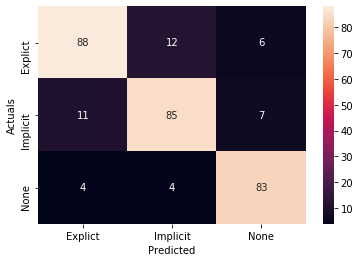

In [ ]:
import seaborn as sns
sns.heatmap(cmi, annot=True, xticklabels=categories[0], yticklabels=categories[0], fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actuals")

In [ ]:
cms = confusion_matrix(df_pred_aux['test_sentiment'].tolist(),df_pred_aux['pred_sentiment'].tolist())

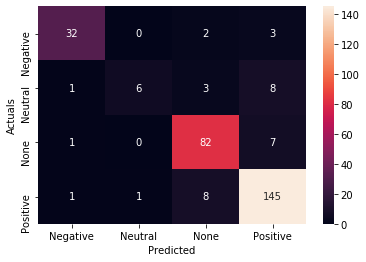

In [ ]:
sns.heatmap(cms, annot=True, xticklabels=categories[1], yticklabels=categories[1], fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actuals")

In [ ]:
cmsub = confusion_matrix(df_pred_aux['test_sub'].tolist(),df_pred_aux['pred_sub'].tolist())

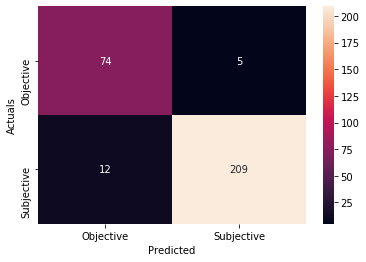

In [ ]:
sns.heatmap(cmsub, annot=True, xticklabels=categories[2], yticklabels=categories[2], fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actuals")

In [ ]:
cmirony = confusion_matrix(df_pred_aux['test_irony'].tolist(),df_pred_aux['pred_irony'].tolist())

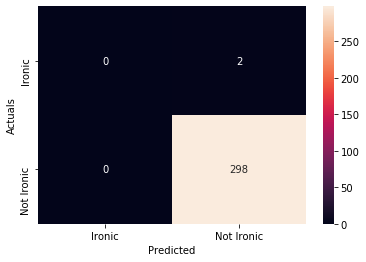

In [ ]:
sns.heatmap(cmirony, annot=True, xticklabels=categories[3], yticklabels=categories[3], fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actuals")

In [ ]:
cme = confusion_matrix(df_pred_aux['test_emotion'].tolist(),df_pred_aux['pred_emotion'].tolist())

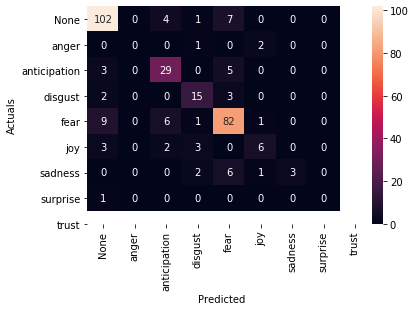

In [ ]:
sns.heatmap(cme, annot=True, xticklabels=categories[4], yticklabels=categories[4], fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actuals")

In [ ]:
df_pred_aux.info()

NameError: name 'df_pred_aux' is not defined

In [ ]:
import pandas as pd
df = pd.read_csv('export_dataframe_pred_0.csv', encoding= 'unicode_escape', sep='\t', engine='python')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 10 columns):
test_implicit     300 non-null object
pred_implicit     300 non-null object
test_sentiment    300 non-null object
pred_sentiment    300 non-null object
test_sub          300 non-null object
pred_sub          300 non-null object
test_irony        300 non-null object
pred_irony        300 non-null object
test_emotion      300 non-null object
pred_emotion      300 non-null object
dtypes: object(10)
memory usage: 23.5+ KB


In [ ]:
df.head()

,test_implicit,pred_implicit,test_sentiment,pred_sentiment,test_sub,pred_sub,test_irony,pred_irony,test_emotion,pred_emotion
0,None,None,None,None,Objective,Objective,Not Ironic,Not Ironic,None,None
1,None,None,None,None,Objective,Objective,Not Ironic,Not Ironic,None,None
2,Implicit,Implicit,Positive,Positive,Subjective,Subjective,Not Ironic,Not Ironic,anticipation,anticipation
3,Implicit,None,Positive,None,Subjective,Objective,Not Ironic,Not Ironic,anticipation,None
4,Explict,Implicit,Positive,Positive,Subjective,Subjective,Not Ironic,Not Ironic,joy,joy


In [ ]:
sub = df['pred_sub'].tolist()
print(sub)

['Objective', 'Objective', 'Subjective', 'Objective', 'Subjective', 'Subjective', 'Subjective', 'Subjective', 'Subjective', 'Objective', 'Subjective', 'Objective', 'Subjective', 'Objective', 'Objective', 'Objective', 'Subjective', 'Objective', 'Subjective', 'Objective', 'Subjective', 'Subjective', 'Subjective', 'Subjective', 'Objective', 'Subjective', 'Objective', 'Subjective', 'Subjective', 'Subjective', 'Subjective', 'Objective', 'Objective', 'Subjective', 'Subjective', 'Subjective', 'Subjective', 'Objective', 'Objective', 'Subjective', 'Subjective', 'Subjective', 'Subjective', 'Objective', 'Subjective', 'Subjective', 'Subjective', 'Subjective', 'Objective', 'Objective', 'Objective', 'Subjective', 'Subjective', 'Objective', 'Subjective', 'Subjective', 'Subjective', 'Subjective', 'Subjective', 'Objective', 'Subjective', 'Subjective', 'Subjective', 'Objective', 'Subjective', 'Objective', 'Objective', 'Objective', 'Subjective', 'Subjective', 'Subjective', 'Objective', 'Subjective', 'Sub

In [ ]:
em = df['pred_emotion'].tolist()
print(em)

['None', 'None', 'anticipation', 'None', 'joy', 'anticipation', 'anticipation', 'None', 'joy', 'None', 'joy', 'None', 'None', 'None', 'None', 'None', 'joy', 'None', 'joy', 'None', 'joy', 'anticipation', 'None', 'joy', 'None', 'anticipation', 'None', 'anticipation', 'joy', 'anticipation', 'anticipation', 'None', 'None', 'anticipation', 'anticipation', 'anticipation', 'anticipation', 'None', 'None', 'None', 'None', 'joy', 'None', 'None', 'anticipation', 'None', 'anticipation', 'None', 'None', 'None', 'None', 'joy', 'None', 'None', 'anticipation', 'anticipation', 'anticipation', 'joy', 'anticipation', 'None', 'anticipation', 'joy', 'None', 'None', 'anticipation', 'None', 'None', 'None', 'joy', 'joy', 'None', 'None', 'joy', 'None', 'joy', 'None', 'joy', 'anticipation', 'None', 'None', 'None', 'None', 'anticipation', 'None', 'None', 'joy', 'joy', 'None', 'None', 'None', 'None', 'joy', 'None', 'None', 'None', 'joy', 'None', 'None', 'joy', 'anticipation', 'None', 'joy', 'joy', 'joy', 'joy', '

In [ ]:
legal = 0
non_legal = 0
not_relevant = 0

for idx,label in enumerate(sub):
    
    if sub[idx] == 'Objective':
        if em[idx] == 'None':
            legal += 1
            
        else:
            non_legal += 1
            
    elif em[idx] == 'None':
        not_relevant += 1
        
    else:
        legal += 1
        
print(legal)
print(non_legal)
print(not_relevant)

tot = legal + non_legal + not_relevant
print(tot)

257
0
43
300
